## load data, make video of given trials, show neuronal activity on the side with go cue

In [387]:
import cv2 
import os 
import suite2p
import scipy
from scipy.io import loadmat as loadmat
import json

import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import matplotlib
from pathlib import Path
#motion_energy_folder = '/home/jupyter/bucket/Data/Behavior_videos/MotionEnergy_manual_ROI_imaging_aligned/'
motion_energy_folder = '/home/jupyter/bucket/temp/BCI_69/MotionEnergy_manual_ROI_imaging_aligned/'
# set where the bpod file is, mouse id and session
#bpod_path = os.path.abspath("/home/jupyter/bucket/Data/Behavior/BCI_exported/Bergamo-2P-Photostim/")
bpod_path = os.path.abspath("/home/jupyter/bucket/temp/BCI_69/bpod")
mouse = "BCI_69"
session = "022824"

# load data
bpod_filepath = os.path.join(bpod_path, session+"-bpod_zaber.npy")
bpod_data = np.load(bpod_filepath, allow_pickle=True).tolist()


motion_energy_filepath = os.path.join(motion_energy_folder, "{}_{}_side_motion_energy.npy".format(mouse,session))
motion_energy_data = np.load(motion_energy_filepath, allow_pickle=True).tolist()

In [349]:
# baselines = np.nanmean(data['F'][0:30,neuron,:],0)
# peaks = np.nanmean(data['F'][40:200,neuron,:],0)
# amplitudes = peaks-baselines
# tuning = np.nanmean(amplitudes,1)

/tmp/ipykernel_23641/2052515916.py:1: RuntimeWarning: Mean of empty slice
  baselines = np.nanmean(data['F'][0:30,neuron,:],0)


In [74]:

# ops_path = os.path.join(data_path_base,'raw_bin_files',session,'ops.npy')
# ops = np.load(ops_path,allow_pickle=True).tolist()

In [388]:
frame_averaging = 10
data_path_base = '/home/jupyter/bucket/temp/BCI_69'

local_path = os.path.join(data_path_base,'data_BCI69_{}.npy'.format(session))
vector = loadmat(os.path.join(data_path_base,'BCI69_021624vector.mat'))
#threshold = loadmat(os.path.join(data_path_base,'neuron239manifold_threshold_28-Feb-2024_16_00_24.mat'))['manifold_thr'][0]

data = np.load(local_path,allow_pickle=True).item()
neuron = np.where(data['iscell'][:,0]==1)[0]
raw = data['F'][:,neuron,:]
org_df = data['df_closedloop'][neuron,:].T
org_df = pd.DataFrame(org_df)
df = org_df.fillna(0)


tuning_vec = vector['vector']

session_dir = os.path.join(data_path_base,'raw_bin_files',session)
raw_F_path = os.path.join(session_dir,'F.npy')
raw_F_closedloop = np.load(raw_F_path)
# raw_Fspont_path = os.path.join(session_dir,'F_spont.npy')
# raw_F_spont = np.load(raw_Fspont_path)
df_closedloop = data['df_closedloop']
raw_F_closedloop_filt = []
for f_now in raw_F_closedloop:
    raw_F_closedloop_filt.append(np.convolve(np.ones(frame_averaging)/frame_averaging,f_now,mode = 'same'))
    
# raw_F_spont_filt = []
# for f_now in raw_F_spont:
#     raw_F_spont_filt.append(np.convolve(np.ones(frame_averaging)/frame_averaging,f_now,mode = 'same'))
raw_F_closedloop_filt = np.asarray(raw_F_closedloop_filt)
# raw_F_spont_filt = np.asarray(raw_F_spont_filt)
projection_trace_filt = np.dot(raw_F_closedloop_filt[neuron,:].T,tuning_vec.T).squeeze()
transformed_trace_filt = raw_F_closedloop_filt[neuron,:]*tuning_vec.T#[:,np.newaxis]
# projection_trace_spont = np.dot(raw_F_spont_filt[neuron,:].T,tuning_vec.T).squeeze()

# mean = np.nanmean(projection_trace_spont[frame_averaging:-frame_averaging])
# projection_trace -= mean
# std = np.nanstd(projection_trace_spont[frame_averaging:-frame_averaging]-mean)
# projection_trace = projection_trace/std

(1, 239)

In [140]:
unique_basenames

'neuron239_flip2'

In [389]:
# align behavior data by scanimage basenames
scanimage_file_names = list()
basenames = list()
file_indices = list()
trial_indices = list()
for trial_i,sfn in enumerate(bpod_data['scanimage_file_names']):
    if type(sfn) == type('no movie for this trial'):
        continue
    else:
        for file in sfn:
            if '_' in file:# and ('cell' in file.lower() or 'stim' in file.lower()):
                basenames.append(file[:-1*file[::-1].find('_')-1])
                try:
                    file_indices.append(int(file[-1*file[::-1].find('_'):file.find('.')]))
                except:
                    print('weird file index: {}'.format(file))
                    file_indices.append(-1)
            else:
                basenames.append(file[:file.find('.')])
                file_indices.append(-1)
            trial_indices.append(trial_i)
            scanimage_file_names.append(file)

            
scanimage_file_names = np.asarray(scanimage_file_names)
basenames =np.asarray(basenames)
file_indices =np.asarray(file_indices)
trial_indices = np.asarray(trial_indices)

unique_basenames = np.unique(basenames)
basenames_order = []
for basename in unique_basenames:
    basenames_order.append(np.argmax(np.asarray(basenames)==basename))
unique_basenames = unique_basenames[np.argsort(basenames_order)]
unique_basenames = [unique_basenames[-1]]

Text(0, 0.5, 'Hit rate')

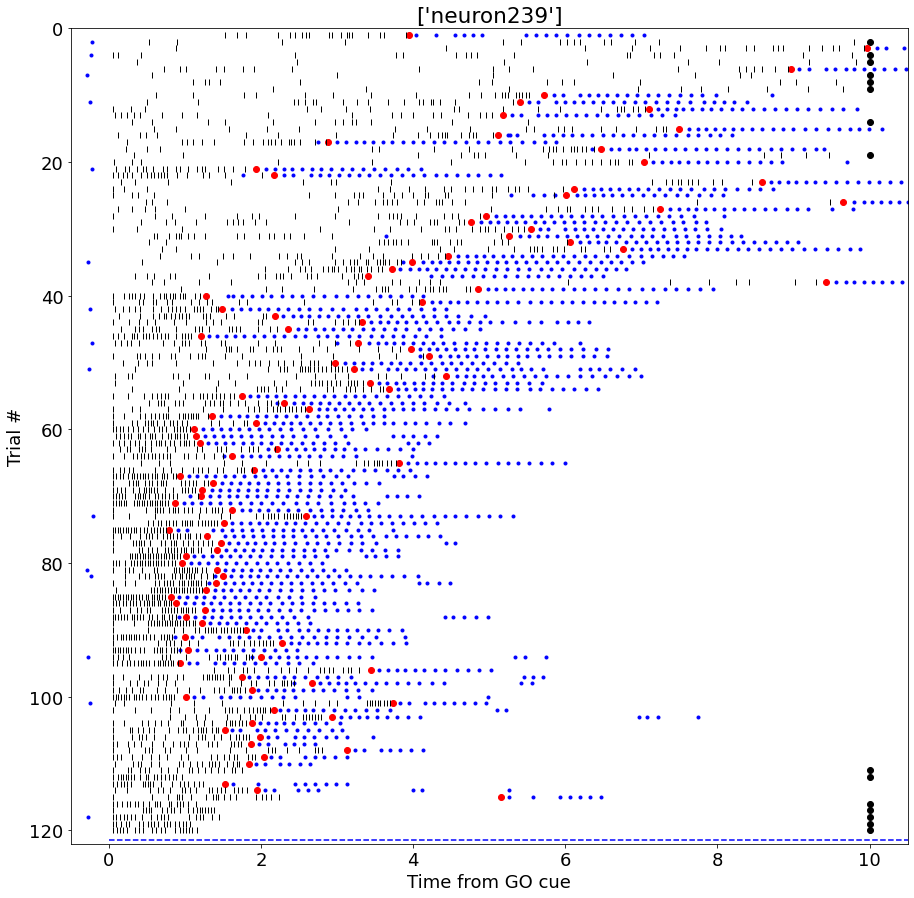

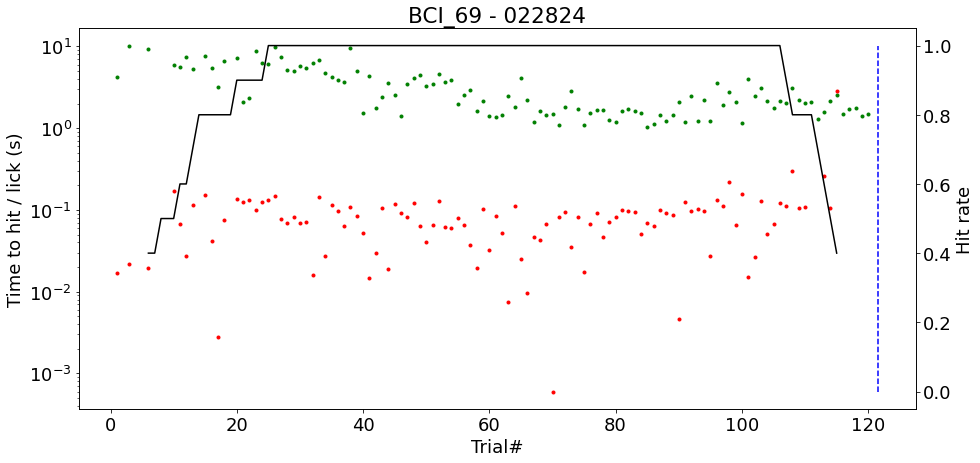

In [390]:
#plot


font = {'family' : 'normal',
        #'weight' : 'bold',
        'size'   : 18}
matplotlib.rc('font', **font)


fig = plt.figure(figsize = [15,15])
ax = fig.add_subplot(1,1,1)
fig2 = plt.figure(figsize = [15,7])
ax_time_to_hit = fig2.add_subplot(1,1,1)
ax_hit = ax_time_to_hit.twinx()
trials_so_far = 1
basenames_plotted = []
time_to_threshold_crossing = []
time_to_lick = []
scanimage_file_name_list  = []
trial_start_frame_nums = []
trial_end_frame_nums = []
frame_nums_so_far = 0

for basename in unique_basenames:
    trials_now = basename==basenames
    trial_indices_now = trial_indices[trials_now]
    hits = []
    trial_indices_to_plot = []
    time_to_threshold_crossing = []
    time_to_lick = []
    for trial_i,trial_idx in enumerate(trial_indices_now):
        go_cue_time = bpod_data['go_cue_times'][trial_idx][0]
        scanimage_trigger_time =bpod_data['Scanimage_trigger_times'][trial_idx][0]
        lick_times =bpod_data['lick_L'][trial_idx]
        reward_times =bpod_data['reward_L'][trial_idx]
        lickport_step_times =bpod_data['zaber_move_forward'][trial_idx]
        threshold_crossing_time = bpod_data['threshold_crossing_times'][trial_idx]
        
        if len(threshold_crossing_time)>0:
            lickport_step_times = lickport_step_times[lickport_step_times<=threshold_crossing_time[0]]
            time_to_threshold_crossing.append(threshold_crossing_time[0])
        else:
            time_to_threshold_crossing.append(np.nan)
        
        zero_time = go_cue_time
        trial_start_frame_nums.append(frame_nums_so_far)
        frame_nums_so_far +=bpod_data['scanimage_tiff_headers'][trial_idx][0]['shape'][0]
        trial_end_frame_nums.append(frame_nums_so_far)
        scanimage_file_name_list.append(bpod_data['scanimage_file_names'][trial_idx][0])
        ax.plot(lick_times-zero_time,np.ones(len(lick_times))*(trial_i+trials_so_far),'b.')
        if len(reward_times)>0:
            ax.plot(reward_times[0]-zero_time,trial_i+trials_so_far,'ro')
            hits.append(1)
            time_to_lick.append(reward_times[0]-threshold_crossing_time[0])
        else:
            ax.plot(10,trial_i+trials_so_far,'ko')
            hits.append(0)
            time_to_lick.append(np.nan)
        trial_indices_to_plot.append(trial_i+trials_so_far)
        ax.plot(lickport_step_times-zero_time,np.ones(len(lickport_step_times))*(trial_i+trials_so_far),'k|')
    trials_so_far += trial_i + 1
    basenames_plotted.append(basename)
    
    ax.hlines(trials_so_far+.5,0,20,color= 'blue',linestyles = 'dashed')
    
    hit_rate = np.convolve(hits,np.ones(10)/10,mode = 'same')
    hit_rate[:5] = np.nan
    hit_rate[-5:] = np.nan
    if len(trial_indices_to_plot)>10:
        ax_hit.plot(trial_indices_to_plot,hit_rate,'k-')
    ax_hit.vlines(trials_so_far+.5,0,1,color= 'blue',linestyles = 'dashed')
    ax_time_to_hit.plot(trial_indices_to_plot,time_to_threshold_crossing,'g.')
    ax_time_to_hit.plot(trial_indices_to_plot,time_to_lick,'r.')
ax_time_to_hit.set_yscale('log')
    
ax_time_to_hit.set_ylabel('')
ax.set_ylim([trials_so_far+1,0])
ax.set_xlim([-.5, 10.5])
ax.set_xlabel('Time from GO cue')
ax.set_ylabel('Trial #')
ax.set_title(basenames_plotted)

ax_time_to_hit.set_ylabel('Time to hit / lick (s)')
ax_time_to_hit.set_xlabel('Trial#')
ax_time_to_hit.set_title('{} - {}'.format(mouse,session))
ax_hit.set_ylabel('Hit rate')

Text(0, 0.5, 'cell count')

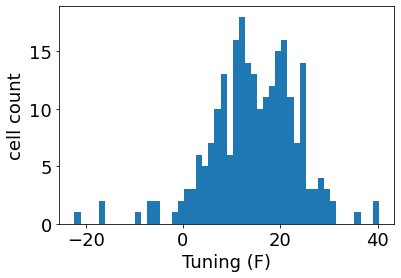

In [363]:
plt.hist(mean_neuron_amplitude_F,50)
plt.xlabel('Tuning (F)')
plt.ylabel('cell count')

/tmp/ipykernel_23641/4030781665.py:39: RuntimeWarning: Mean of empty slice
  projection_baselines = np.nanmean(projection_matrix[:,baseline_idx],1)
/tmp/ipykernel_23641/4030781665.py:43: RuntimeWarning: Mean of empty slice
  neuron_baselines = np.nanmean(neuron_projection_matrix[:,:,baseline_idx],2)
/tmp/ipykernel_23641/4030781665.py:47: RuntimeWarning: Mean of empty slice
  neuron_baselines_F = np.nanmean(neuron_amplitude_matrix[:,:,baseline_idx],2)


Text(0, 0.5, 'Projection amplitude')

<Figure size 432x288 with 0 Axes>

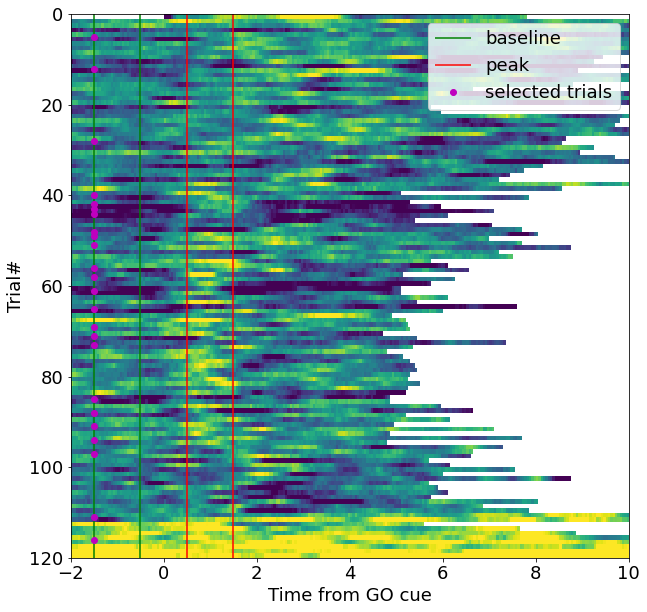

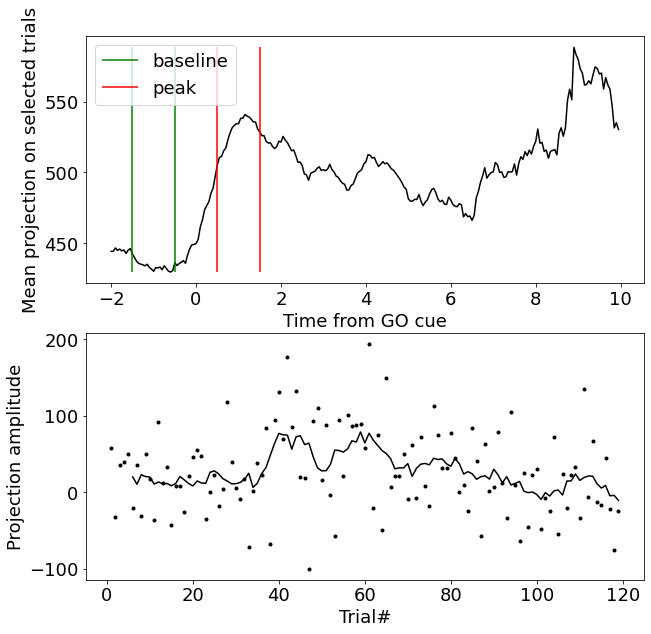

In [447]:
plt.set_cmap('viridis')
frames_back = 40
frames_forward = 200
projection_matrix = np.ones([len(trial_start_frame_nums),frames_back+frames_forward])*np.nan # trials x time
neuron_projection_matrix = np.ones([transformed_trace_filt.shape[0],len(trial_start_frame_nums),frames_back+frames_forward])*np.nan # neurons x trials x time
neuron_amplitude_matrix = np.ones([transformed_trace_filt.shape[0],len(trial_start_frame_nums),frames_back+frames_forward])*np.nan # neurons x trials x time
for trial_i,(s,e) in enumerate(zip(trial_start_frame_nums,trial_end_frame_nums)):
    start_idx = np.max([0,s-frames_back])
    end_idx = np.min([e,s+frames_forward])
    if trial_i == 0:
        s_=frames_back
    else:
        s_ = 0
    
    e_ = s_ +end_idx - start_idx
    projection_matrix[trial_i,s_:e_] = projection_trace_filt[start_idx:end_idx]
    neuron_projection_matrix[:,trial_i,s_:e_] = transformed_trace_filt[:,start_idx:end_idx]
    neuron_amplitude_matrix[:,trial_i,s_:e_] = raw_F_closedloop_filt[neuron,start_idx:end_idx]

#projection_trace_filt
projection_matrix_norm = projection_matrix# - np.nanmean(projection_matrix[:,:frames_back-10],1)[:,np.newaxis]
fig = plt.figure(figsize = [10,10])
im = plt.imshow(projection_matrix_norm,aspect = 'auto',interpolation = 'none',extent = [-frames_back/20,frames_forward/20,projection_matrix_norm.shape[0],0])
im.set_clim(np.percentile(projection_trace_filt,[5,95]))
#im.set_clim([-55,50])
plt.xlabel('Time from GO cue')
plt.ylabel('Trial#')

time_trace  =np.arange(-frames_back,frames_forward)/20

trial_start = 50
trial_end = 90
needed_trials = projection_amplitudes>np.nanstd(projection_amplitudes)
baseline_t = [-1.5,-.5]
peak_t  =[0.5,1.5]
baseline_idx = (time_trace>baseline_t[0]) & (time_trace<baseline_t[1])
peak_idx = (time_trace>peak_t[0]) & (time_trace<peak_t[1])

projection_baselines = np.nanmean(projection_matrix[:,baseline_idx],1)
projection_peaks = np.nanmean(projection_matrix[:,peak_idx],1)
projection_amplitudes = projection_peaks - projection_baselines

neuron_baselines = np.nanmean(neuron_projection_matrix[:,:,baseline_idx],2)
neuron_peaks = np.nanmean(neuron_projection_matrix[:,:,peak_idx],2)
neuron_amplitudes = neuron_peaks-neuron_baselines

neuron_baselines_F = np.nanmean(neuron_amplitude_matrix[:,:,baseline_idx],2)
neuron_peaks_F = np.nanmean(neuron_amplitude_matrix[:,:,peak_idx],2)
neuron_amplitudes_F = neuron_peaks_F-neuron_baselines_F


mean_projection_amplitude = np.nanmean(projection_amplitudes[needed_trials])
std_projection_amplitude = np.nanstd(projection_amplitudes[needed_trials])

mean_neuron_amplitude = np.nanmean(neuron_amplitudes[:,needed_trials],1)
std_neuron_amplitude = np.nanstd(neuron_amplitudes[:,needed_trials],1)
se_neuron_amplitude = np.nanstd(neuron_amplitudes[:,needed_trials],1)/np.sqrt(sum(needed_trials))


mean_neuron_amplitude_F = np.nanmean(neuron_amplitudes_F[:,needed_trials],1)
std_neuron_amplitude_F = np.nanstd(neuron_amplitudes_F[:,needed_trials],1)
se_neuron_amplitude_F = np.nanstd(neuron_amplitudes_F[:,needed_trials],1)/np.sqrt(sum(needed_trials))


plt.vlines(baseline_t,projection_matrix_norm.shape[0],0,color = 'green',label = 'baseline')
plt.vlines(peak_t,projection_matrix_norm.shape[0],0,color = 'red',label = 'peak')
plt.plot(np.ones(sum(needed_trials))*-1.5,np.where(needed_trials)[0],'mo',label = 'selected trials')
plt.legend()

mean_projection_trace = np.nanmean(projection_matrix_norm[needed_trials,:],0)

fig = plt.figure(figsize = [10,10])
ax1= fig.add_subplot(2,1,1)
plt.plot(time_trace,mean_projection_trace,'k-')
plt.vlines(baseline_t,np.min(mean_projection_trace),np.max(mean_projection_trace),color = 'green',label = 'baseline')
plt.vlines(peak_t,np.min(mean_projection_trace),np.max(mean_projection_trace),color = 'red',label = 'peak')
plt.xlabel('Time from GO cue')
plt.ylabel('Mean projection on selected trials')
plt.legend()
ax2= fig.add_subplot(2,1,2)
ax2.plot(projection_amplitudes,'k.')
ax2.plot(np.convolve(projection_amplitudes,np.ones(10)/10,'same'),'k-')
ax2.set_xlabel('Trial#')
ax2.set_ylabel('Projection amplitude')

Text(0, 0.5, 'Corrected contribution to peak')

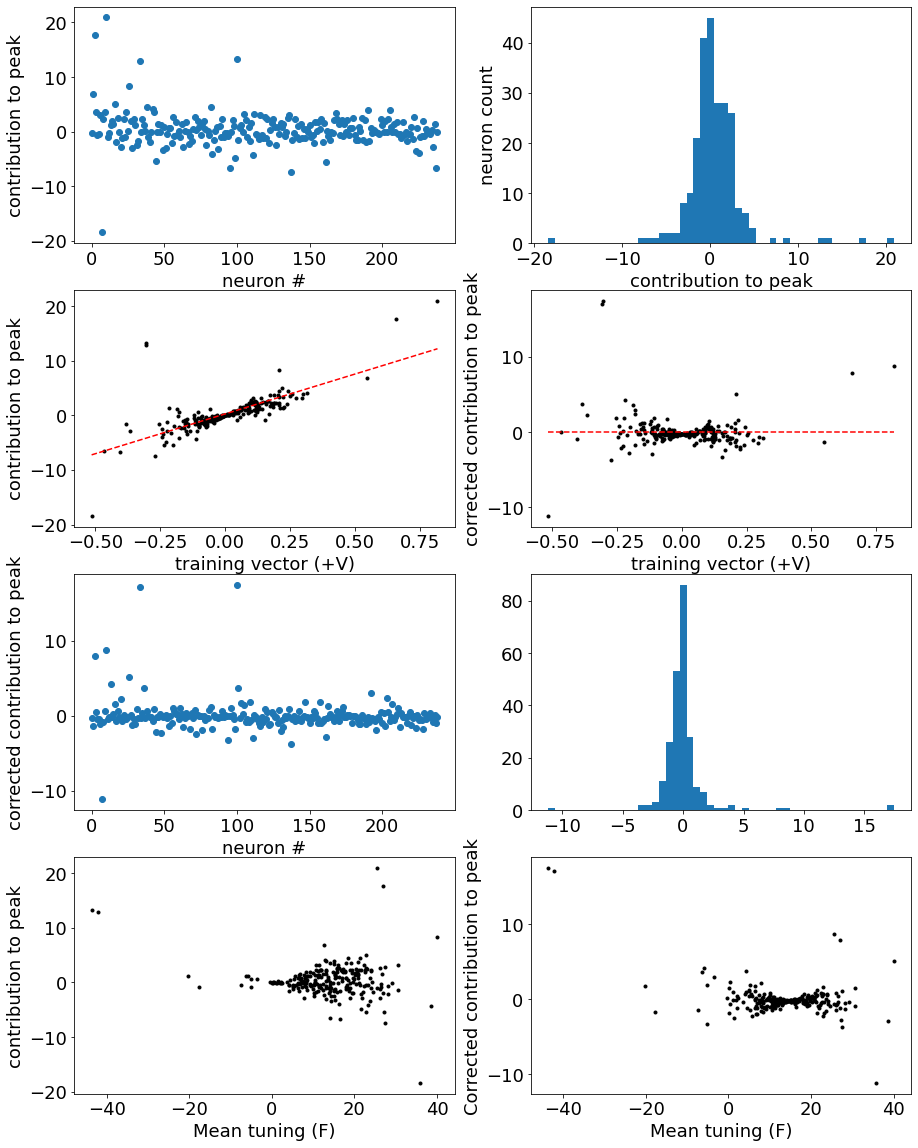

In [450]:
fig = plt.figure(figsize = [15,20])
ax1 = fig.add_subplot(4,2,1)
#ax1.errorbar(np.arange(len(mean_neuron_amplitude)),mean_neuron_amplitude,std_neuron_amplitude,fmt='o')
ax1.plot(np.arange(len(mean_neuron_amplitude)),mean_neuron_amplitude,'o')
ax1.set_xlabel('neuron #')
ax1.set_ylabel('contribution to peak')
ax2 = fig.add_subplot(4,2,2)
ax2.hist(mean_neuron_amplitude,50)
ax2.set_xlabel('contribution to peak')
ax2.set_ylabel('neuron count')

ax3 = fig.add_subplot(4,2,3)
ax3.plot(tuning_vec.squeeze(),mean_neuron_amplitude,'k.')
ax3.set_xlabel('training vector (+V)')
ax3.set_ylabel('contribution to peak')
x = tuning_vec.squeeze()
y = mean_neuron_amplitude
p = np.polyfit(x,y,1)
x_ = np.percentile(x,[0,100])
ax3.plot(x_,np.polyval(p,x_),'r--')
corrected_contribution_to_peak = y - np.polyval(p,x)

ax3 = fig.add_subplot(4,2,4)
ax3.plot(tuning_vec.squeeze(),corrected_contribution_to_peak,'k.')
ax3.set_xlabel('training vector (+V)')
ax3.set_ylabel('corrected contribution to peak')
y = corrected_contribution_to_peak
p = np.polyfit(x,y,1)
x_ = np.percentile(x,[0,100])
ax3.plot(x_,np.polyval(p,x_),'r--')



ax1 = fig.add_subplot(4,2,5)
ax1.plot(np.arange(len(corrected_contribution_to_peak)),corrected_contribution_to_peak,'o')
ax1.set_xlabel('neuron #')
ax1.set_ylabel('corrected contribution to peak')


ax4 = fig.add_subplot(4,2,6)
ax4.hist(corrected_contribution_to_peak,50)

#ax4 = fig.add_subplot(3,2,4)

ax8 = fig.add_subplot(4,2,7)
ax8.plot(mean_neuron_amplitude_F,mean_neuron_amplitude,'k.')
#ax8.errorbar(mean_neuron_amplitude_F,mean_neuron_amplitude,se_neuron_amplitude,se_neuron_amplitude_F,fmt = '.',color='black',alpha = .5)
ax8.set_xlabel('Mean tuning (F)')
ax8.set_ylabel('contribution to peak')

ax8 = fig.add_subplot(4,2,8)
ax8.plot(mean_neuron_amplitude_F,corrected_contribution_to_peak,'k.')
ax8.set_xlabel('Mean tuning (F)')
ax8.set_ylabel('Corrected contribution to peak')

/tmp/ipykernel_23641/1092215906.py:11: RuntimeWarning: Mean of empty slice
  projection_baselines = np.nanmean(projection_matrix[:,baseline_idx],1)
/tmp/ipykernel_23641/1092215906.py:15: RuntimeWarning: Mean of empty slice
  neuron_baselines = np.nanmean(neuron_projection_matrix[:,:,baseline_idx],2)


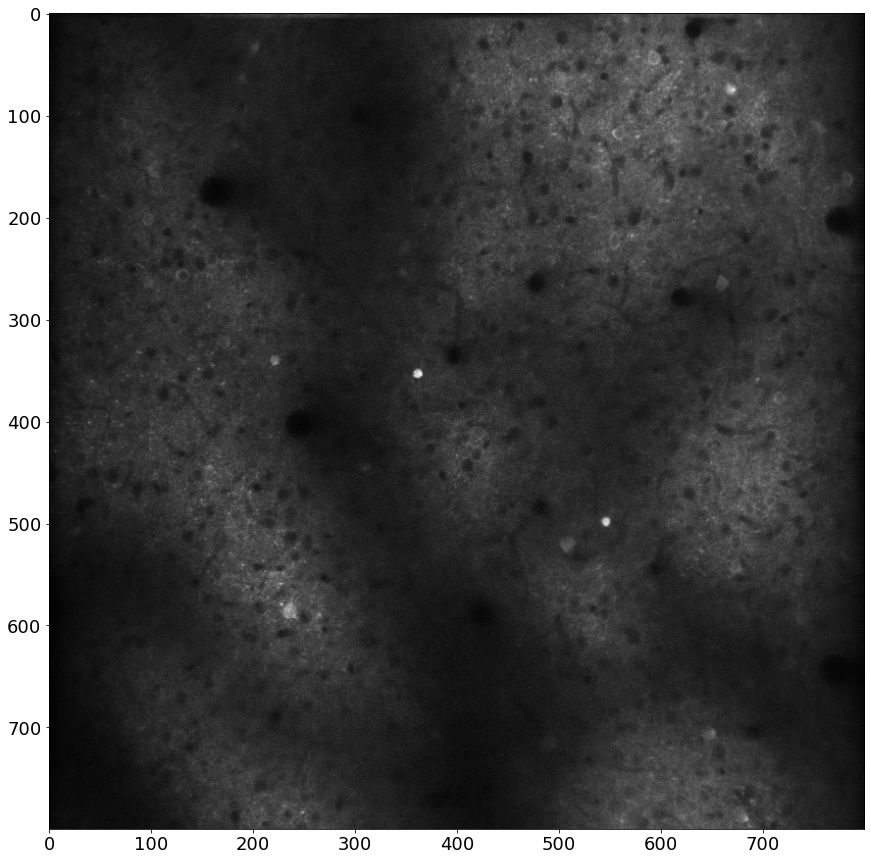

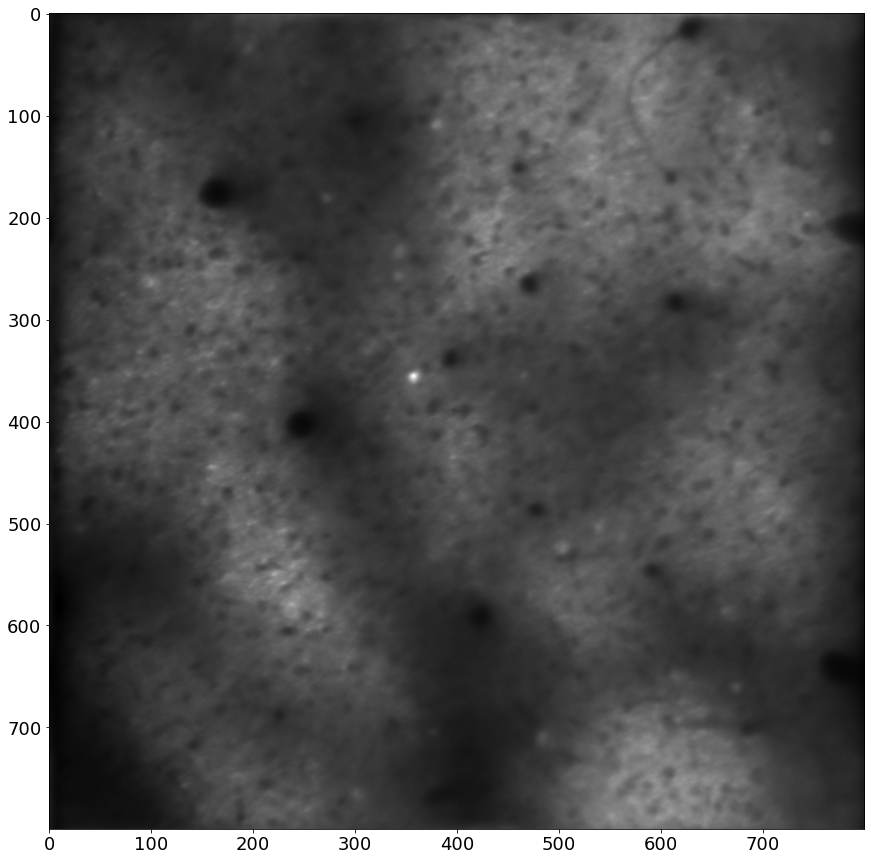

In [230]:
fig = plt.figure(figsize = [15,15])
plt.imshow(ops['refImg'])
fig = plt.figure(figsize = [15,15])
plt.imshow(ops['meanImg'])

In [371]:
l = []
for i in np.arange(47,51):
    l.append(scanimage_file_name_list[i])
l

['neuron239_flip2_00048.tif',
 'neuron239_flip2_00049.tif',
 'neuron239_flip2_00050.tif',
 'neuron239_flip2_00051.tif']

In [381]:

setup = 'Bergamo-2P-Photostim'
BinaryFile = suite2p.io.BinaryFile
all_dff_traces = []
all_projection_traces = []
all_dff_times = []
all_frames = []
all_go_cue_times = []
all_lick_times = []
all_lickport_step_times = []
all_reward_times = []
start_time = 0
frame_idx_list = []
for trial_i in np.arange(47,51):
    trial_si_name = scanimage_file_name_list[trial_i]

    
    si_start_frame = trial_start_frame_nums[trial_i]
    si_end_frame = trial_end_frame_nums[trial_i]
    frame_idx_list.append(np.arange(si_start_frame,si_end_frame))
    for bpod_trial_i, scname in enumerate(bpod_data['scanimage_file_names']):
        if trial_si_name == scname[0]:
            break
    frame_rate = float(bpod_data['scanimage_tiff_headers'][bpod_trial_i][0]['frame_rate'])
    projection_trace  =projection_trace_filt[si_start_frame:si_end_frame]
    dff_time = np.arange(len(projection_trace))/frame_rate
    # dff_trace = np.kron(dff_trace,np.ones(2))
    # dff_time = np.kron(dff_time,np.ones(2))
    lickport_step_times = bpod_data['zaber_move_forward'][bpod_trial_i]
    lick_times = bpod_data['lick_L'][bpod_trial_i]
    reward_times = bpod_data['reward_L'][bpod_trial_i]
    go_cue_times= bpod_data['go_cue_times'][bpod_trial_i]
    threshold_crossing_times= bpod_data['threshold_crossing_times'][bpod_trial_i]
    

    video_base_dir = '/home/jupyter/bucket/Data/Behavior_videos/raw/'+setup
    camera = 'side'
    for video_i in range(len(bpod_data['behavior_movie_name_list'][bpod_trial_i])):
        video_file = os.path.join(video_base_dir,bpod_data['behavior_movie_name_list'][bpod_trial_i][video_i].strip(' "').strip("'")[len('/home/labadmin/Data/Behavior_videos/'):])
        if camera in video_file:
            break
    video_metadata_file = video_file[:-4]+'.json'
    with open(video_metadata_file, 'r') as f:
        video_dict = json.load(f)

    video_indices = []
    for t in dff_time:
        video_indices.append(np.argmin(np.abs(video_dict['frame_times']-t)))

    video = cv2.VideoCapture(video_file) 

    currentframe = -1
    frame_list = []
    while(True): 
        ret,frame = video.read() 
        if ret: 
            currentframe += 1
            if currentframe in video_indices:
                for _ in range(sum(np.asarray(video_indices) == currentframe)):
                    frame_list.append(frame)
            
        else: 
            break
    #cv2.destroyAllWindows()
    
    #all_dff_traces.append(dff_trace)
    all_projection_traces.append(projection_trace)
    all_dff_times.append(dff_time+start_time)
    all_frames.append(frame_list)
    all_go_cue_times.append(go_cue_times+start_time)
    all_lick_times.append(lick_times+start_time)
    all_reward_times.append(reward_times+start_time)
    all_lickport_step_times.append(lickport_step_times+start_time)
    start_time += dff_time[-1]

ops =  np.load(os.path.join(session_dir,'ops.npy'),allow_pickle = True).tolist()
binaryfile = os.path.join(session_dir,'data.bin')
frames_needed = np.concatenate(frame_idx_list)
with BinaryFile(Ly=ops['Ly'], Lx=ops['Lx'], read_filename=binaryfile) as f:   
    frames  =f.ix(frames_needed)   
    
    

#ax_lickport.set_xlim([5,10])


#all_dff_traces = np.concatenate(all_dff_traces)
all_projection_traces = np.concatenate(all_projection_traces)
all_dff_times = np.concatenate(all_dff_times)
all_frames = np.concatenate(all_frames)
all_go_cue_times = np.concatenate(all_go_cue_times)
all_lick_times = np.concatenate(all_lick_times)
all_lickport_step_times = np.concatenate(all_lickport_step_times)
all_reward_times= np.concatenate(all_reward_times)

#frames_filt = scipy.ndimage.gaussian_filter(frames, [5,0,0])
frames_filt = []
window = 10
for frame_i,frame in enumerate(frames):
    start_ = np.max([0,frame_i-window])
    end_ = start_+window
    frames_filt.append(np.asarray(np.mean(frames[start_:end_],0),dtype = np.int16))
frames_filt = np.asarray(frames_filt)
    

In [172]:
all_lickport_step_times

array([ 0.4538    ,  0.7058    ,  1.2118    ,  1.5848    ,  1.6897    ,
        1.9767    ,  2.2057    ,  2.3077    ,  2.4537    ,  2.6957    ,
        3.6576    ,  3.6916    ,  3.7256    ,  3.7596    ,  3.8116    ,
        3.8636    ,  3.9146    ,  3.9666    ,  4.0926    ,  4.1636    ,
        9.68012054, 11.37302054, 11.55602054, 11.73502054, 11.78102054,
       11.84602054, 11.92792054, 12.09292054, 12.29192054, 12.37692054,
       12.46292054, 12.53492054, 12.60692054, 12.65192054, 12.69592054,
       12.79392054, 12.88992054, 12.98692054, 13.02092054, 20.61744922,
       22.07334922, 22.97634922, 23.92524922, 24.03524922, 25.14114922,
       25.18214922, 25.34714922, 25.60514922, 25.75514922, 25.79414922,
       25.83214922, 25.88014922, 25.93214922, 25.99914922, 26.05814922,
       26.33604922, 26.44904922, 26.50604922, 32.68472203, 32.87772203,
       32.97272203, 33.06772203, 33.25172203, 35.14152203, 35.38052203,
       35.43152203, 35.53952203, 35.59652203, 35.63452203, 35.77

In [382]:
import subprocess
import shutil
from matplotlib.gridspec import GridSpec
import gc

save_dir = '/home/jupyter/temp/video'

fig = plt.figure(figsize = [15,8])

p2_pixel_range = 200

gs1 = GridSpec(2, 2, height_ratios=[5, 1],width_ratios = [3,4])
ax_trace = fig.add_subplot(gs1[1, :])
ax_2p = fig.add_subplot(gs1[0, 0])
ax_faceimage = fig.add_subplot(gs1[0, 1])



# ax_trace = fig.add_subplot(2,2,1)
# ax_lickport = fig.add_subplot(2,2,3,sharex = ax_trace)
# ax_faceimage = fig.add_subplot(2,2,2)

plt.set_cmap('gray')
clims_2p = np.percentile(frames_filt.flatten(),[5,99.99])#clims_2p = [np.percentile(frames_filt.flatten(),5),np.max(frames_filt.flatten())]
clims_video = np.percentile(all_frames.flatten(),[5,99.99])
for frame in range(len(all_projection_traces)-1):
    #frame = len(all_projection_traces)-1
    ax_2p.cla()
    im = ax_2p.imshow(frames_filt[frame])
    im.set_clim(clims_2p)
    # ax_2p.plot(stat[cn_idx]['med'][1],stat[cn_idx]['med'][0], 'o',markersize = 25, markerfacecolor='none', markeredgecolor='r')
    # ax_2p.set_xlim([np.max([0,stat[cn_idx]['med'][1]-p2_pixel_range]),np.min([frames_filt.shape[1],stat[cn_idx]['med'][1]+p2_pixel_range])])
    # ax_2p.set_ylim([np.max([0,stat[cn_idx]['med'][0]-p2_pixel_range]),np.min([frames_filt.shape[0],stat[cn_idx]['med'][0]+p2_pixel_range])])
    ax_2p.axis('off')
    ax_faceimage.cla()
    im_face = ax_faceimage.imshow(all_frames[frame][:,50:-200,0])#[:400,100:-200,0])
    im_face.set_clim(clims_video)
    ax_faceimage.axis('off')
    
    ax_trace.cla()
    ax_trace.plot(all_dff_times[:frame],all_projection_traces[:frame],'k-')

    
    # ax_lickport.cla()
    reward_needed = all_reward_times<=all_dff_times[frame]
    ax_trace.plot(all_reward_times[reward_needed],np.ones(sum(reward_needed))*np.percentile(all_projection_traces,[90]),'o',color='lightblue',markersize = 11,alpha = 1)
    ax_trace.plot(all_reward_times[reward_needed],np.ones(sum(reward_needed))*np.percentile(all_projection_traces,[90])+15,'^',color='lightblue',markersize = 11,alpha = 1)
    # lick_needed = all_lick_times<=all_dff_times[frame]
    # ax_lickport.plot(all_lick_times[lick_needed],np.ones(sum(lick_needed))*2,'b|')
    # lickport_steps_needed = all_lickport_step_times<=all_dff_times[frame]
    # ax_trace.plot(all_lickport_step_times[lickport_steps_needed],np.ones(sum(lickport_steps_needed))*np.percentile(all_projection_traces,[95]),'ko')
    go_cue_times_needed = all_go_cue_times<=all_dff_times[frame]
    #ax_trace.plot(all_go_cue_times[go_cue_times_needed],np.ones(sum(go_cue_times_needed))*np.percentile(all_projection_traces,[95]),'go')
    ax_trace.vlines(all_go_cue_times[go_cue_times_needed],np.percentile(all_projection_traces,0),np.percentile(all_projection_traces,100),color = 'green')
    
    ax_trace.set_xlim([all_dff_times[0],all_dff_times[-1]])
    ax_trace.set_ylim(np.percentile(all_projection_traces,[0,100]))
    ax_trace.spines['top'].set_visible(False)
    ax_trace.spines['right'].set_visible(False)
    ax_trace.set_ylabel('projection')
    ax_trace.set_xlabel('Time (s)')
    ax_trace.spines['top'].set_visible(False)
    #asdasdassa
    plt.savefig(save_dir + "/file%02d.png" % frame)
    
plt.close()
gc.collect()
os.chdir(save_dir)

# subprocess.call([
#     'ffmpeg', '-framerate', '20', '-i', 'file%02d.png', '-r', '20', '-pix_fmt', 'yuv420p',
#     'sample_bci_video.mp4'
# ])
# for file_name in os.listdir(save_dir):
#     if '.png' in file_name:
#         os.remove(file_name)
# shutil.move(os.path.join(save_dir,'sample_bci_video.mp4'),'/home/jupyter/bucket/sample_manifold_bci_video.mp4')

In [170]:
lickport_steps_needed

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True])

In [385]:
subprocess.call([
    'ffmpeg', '-framerate', '20', '-i', 'file%02d.png', '-r', '20', '-pix_fmt', 'yuv420p',#'-b', '2000k',
    'sample_bci_video.mp4'
])
# for file_name in os.listdir(save_dir):
#     if '.png' in file_name:
#         os.remove(file_name)
shutil.move(os.path.join(save_dir,'sample_bci_video.mp4'),'/home/jupyter/bucket/BCI69_022924_sample_manifold_bci_video2_lowquality_v2.mp4')

ffmpeg version 4.1.11-0+deb10u1 Copyright (c) 2000-2023 the FFmpeg developers
  built with gcc 8 (Debian 8.3.0-6)
  configuration: --prefix=/usr --extra-version=0+deb10u1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --e

'/home/jupyter/bucket/BCI69_022924_sample_manifold_bci_video2_lowquality_v2.mp4'

In [386]:
for file_name in os.listdir(save_dir):
    if '.png' in file_name:
        os.remove(file_name)